# Predictor for Drug-induced Liver Injury (DILI)

## Training datasets: 

1. **FDA Drug Induced Liver Injury Rank (DILIrank) Dataset** , https://www.fda.gov/science-research/liver-toxicity-knowledge-base-ltkb/drug-induced-liver-injury-rank-dilirank-dataset.

2. **DL-DILI-Liew** and **DL-DILI-combined** datasets from DL-DILI project http://www.pkumdl.cn:8080/DILIserver/DILIhome.php

3. **Chen Dataset** (LTKB Benchmark Dataset, from Chen M. et al. (2013) *Quantitative Structure-Activity Relationship Models for Predicting Drug-Induced Liver Injury Based on FDA-Approved Drug Labeling Annotation and Using a Large Collection of Drugs*, https://doi.org/10.1093/toxsci/kft189) 

In [5]:
#!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#!pip install padelpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#!pip install xlrd==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from  rdkit.Chem.Scaffolds import MurckoScaffold

In [20]:
# Support for RDKit-ROMol in Pandas
from rdkit.Chem import PandasTools

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [22]:
from sklearn._config import set_config
set_config(print_changed_only=False)

In [23]:
from pycm import ConfusionMatrix

### Dataset preparation

In [24]:
# Load dataset 1 (FDA Rank)
fda = pd.read_excel('Input/FDA_DILIrank.xlsx', header=1)

In [25]:
fda

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2
4,LT00011,clofibrate,3,Warnings and precautions,vLess-DILI-Concern,1
...,...,...,...,...,...,...
1031,LT02449,sitaxsentan,8,Withdrawn,vMost-DILI-Concern,2
1032,LT02907,laronidase,4,Adverse reactions,Ambiguous DILI-concern,2
1033,LT02909,dexmethylphenidate,7,Adverse reactions,vLess-DILI-Concern,2
1034,LT02913,hyaluronidase recombinant human,0,No match,vNo-DILI-Concern,2


In [26]:
fda['Severity Class'].value_counts()

0    338
3    309
8    159
5     62
7     60
4     53
2     46
6      5
1      4
Name: Severity Class, dtype: int64

In [27]:
fda[fda.vDILIConcern.str.contains('Most-DILI', case=False)]

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
0,LT00003,mercaptopurine,8,Warnings and precautions,vMost-DILI-Concern,1
1,LT00004,acetaminophen,5,Warnings and precautions,vMost-DILI-Concern,2
2,LT00006,azathioprine,5,Warnings and precautions,vMost-DILI-Concern,1
9,LT00020,gemfibrozil,4,Warnings and precautions,vMost-DILI-Concern,1
10,LT00022,indomethacin,8,Warnings and precautions,vMost-DILI-Concern,1
...,...,...,...,...,...,...
997,LT02121,nandrolone decanoate,7,Warnings and precautions,vMost-DILI-Concern,2
1004,LT02204,lapatinib,8,Box warning,vMost-DILI-Concern,1
1006,LT02213,alaproclate,8,Withdrawn,vMost-DILI-Concern,1
1007,LT02216,orlistat,8,Warnings and precautions,vMost-DILI-Concern,1


In [28]:
fda[fda.vDILIConcern.str.contains('No-DILI', case=False)]

,LTKBID,Compound Name,Severity Class,Label Section,vDILIConcern,Version
3,LT00009,chlorpheniramine,0,No match,vNo-DILI-Concern,2
6,LT00015,dopamine,0,No match,vNo-DILI-Concern,2
12,LT00024,mannitol,0,No match,vNo-DILI-Concern,1
28,LT00054,aminohippurate,0,No match,vNo-DILI-Concern,2
40,LT00074,dimercaprol,0,No match,vNo-DILI-Concern,2
...,...,...,...,...,...,...
1024,LT02385,agalsidase beta,0,No match,vNo-DILI-Concern,2
1025,LT02404,gadolinium ethoxybenzyl DTPA,0,No match,vNo-DILI-Concern,2
1029,LT02437,Levoleucovorin,0,No match,vNo-DILI-Concern,2
1030,LT02442,levomefolate calcium,0,No match,vNo-DILI-Concern,2


In [ ]:
# Load dataset 2 (DL-DILI-Liew)
liew_train = pd.read_csv('Input/DL-DILI-Liew_train_dataset.csv')
liew_train

,smiles,label
0,CC(Cl)(Cl)Cl,1
1,C(C(Cl)Cl)Cl,1
2,CN(C)N,1
3,C(C=CCl)Cl,1
4,Cc1c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-],1
...,...,...
1060,CN(C)CCc1c[nH]c2c1cc(cc2)CC3COC(=O)N3,0
1061,Cc1ccc(cc1)c2c(n3cc(ccc3n2)C)CC(=O)N(C)C,1
1062,c1ccc2c(c1)c(no2)CS(=O)(=O)N,1
1063,CN1CCN(CC1)C(=O)OC2c3c(nccn3)C(=O)N2c4ccc(cn4)Cl,0


In [ ]:
liew_train.label.value_counts()

1    648
0    417
Name: label, dtype: int64

In [ ]:
liew_test = pd.read_csv('Input/DL-DILI-Liew_test_dataset.csv')
liew_test

,smiles,label
0,c1ccc2c(c1)cccc2N=C=S,1
1,CCOCCO,1
2,CCCC(=O)Nc1ccc(c(c1)C(=O)C)OCC(CNC(C)C)O,1
3,CC1(C(N2C(S1)C(C2=O)N=CN3CCCCCC3)C(=O)O)C,1
4,c1cc(c(c2c1NC3=NC(=O)CN3C2)Cl)Cl,0
...,...,...
114,CC12CCC3C(C1CCC2O)CCC45C3(CC(=C(C4O5)O)C#N)C,0
115,CN1C2CCC1CC(C2)OC(=O)c3c[nH]c4c3cccc4,1
116,CN1CCc2cc(c3cc2C1Cc4ccc(cc4)Oc5c6c(cc(c5O)OC)C...,0
117,C(=O)(N)N,0


In [ ]:
# Additional validation dataset of Greene et. al. (from Chen publication)
chen_greene = pd.read_excel('Input/Chen_dataset.xls', sheet_name=2)
chen_greene

,Pubchem,CompoundName,Greene et al.annotation,QSAR Prediction
0,4723,pemoline,HH,1
1,2333,benzbromarone,HH,1
2,4495,nimesulide,HH,1
3,35935,pirprofen,HH,1
4,39941,benoxaprofen,HH,1
...,...,...,...,...
323,447458,ragaglitazar,NE,1
324,16682734,bismuth subsalicylate,NE,1
325,54677972,isoxicam,NE,1
326,892,inositol,NE,0


In [29]:
# Load dataset 3 (Chen)
chen0 = pd.read_excel('Input/Chen_datasets.xls', sheet_name=0)
chen1 = pd.read_excel('Input/Chen_datasets.xls', sheet_name=1)

In [30]:
chen_original = pd.concat([chen0, chen1], axis=0)

In [31]:
chen_original

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction
0,3474,glafenine,Most DILI-concern,NaN
1,2478,busulfan,Most DILI-concern,NaN
2,2520,verapamil,Most DILI-concern,NaN
3,2662,celecoxib,Most DILI-concern,NaN
4,2898,cyclofenil,Most DILI-concern,NaN
...,...,...,...,...
185,11033,sulfacarbamide,Most DILI-concern,0.0
186,6179,mebanazine,Most DILI-concern,0.0
187,71467,phenoxypropazine,Most DILI-concern,0.0
188,114965,tetrabamate,Most DILI-concern,0.0


In [33]:
chen_original.drop_duplicates('PubChem')

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction
0,3474,glafenine,Most DILI-concern,NaN
1,2478,busulfan,Most DILI-concern,NaN
2,2520,verapamil,Most DILI-concern,NaN
3,2662,celecoxib,Most DILI-concern,NaN
4,2898,cyclofenil,Most DILI-concern,NaN
...,...,...,...,...
185,11033,sulfacarbamide,Most DILI-concern,0.0
186,6179,mebanazine,Most DILI-concern,0.0
187,71467,phenoxypropazine,Most DILI-concern,0.0
188,114965,tetrabamate,Most DILI-concern,0.0


In [34]:
# fetching SMILES from PubChem
chen_original.PubChem.to_csv('Output/chen_list.csv', index=None, header=None)

In [35]:
chen_pubchem = pd.read_csv('Input/chen_pubchem.csv')
chen_pubchem

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,247,Betaine,betaine|107-43-7|glycine betaine|oxyneurine|ly...,117.15,C5H11NO2,40.1,87.6,0.5,8,0,...,KWIUHFFTVRNATP-UHFFFAOYSA-N,2-(trimethylazaniumyl)acetate,Betaine,Biological Test Results|Biomolecular Interacti...,14,192|248|608|1033|1195|1549|1552|1637|1648|7104...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
1,298,"2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...","2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...",323.13,C11H12Cl2N2O5,115.0,342.0,1.1,20,3,...,WIIZWVCIJKGZOK-UHFFFAOYSA-N,"2,2-dichloro-N-[1,3-dihydroxy-1-(4-nitrophenyl...",NaN,Biological Test Results|Chemical and Physical ...,8,155|157|175|248|256|328|485|631|731|757|758|75...,20050325,001Chemical|AAA Chemistry|abcr GmbH|ABI Chem|A...,Chemical Vendors|Curation Efforts|Governmental...,NaN
2,338,Salicylic acid,salicylic acid|2-Hydroxybenzoic acid|69-72-7|o...,138.12,C7H6O3,57.5,133.0,2.3,10,2,...,YGSDEFSMJLZEOE-UHFFFAOYSA-N,2-hydroxybenzoic acid,Salicylic Acid,Biological Test Results|Biomolecular Interacti...,14,155|157|161|165|167|175|179|248|485|568|583|59...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,453,Hexitol,"Hexitol|hexane-1,2,3,4,5,6-hexaol|hexane-1,2,3...",182.17,C6H14O6,121.0,105.0,-3.1,12,6,...,FBPFZTCFMRRESA-UHFFFAOYSA-N,"hexane-1,2,3,4,5,6-hexol",NaN,Biological Test Results|Classification|Literat...,6,155|157|161|165|167|175|188|200|208|214|220|24...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
4,679,Dimethyl sulfoxide,dimethyl sulfoxide|DMSO|67-68-5|Methyl sulfoxi...,78.14,C2H6OS,36.3,29.0,-0.6,4,0,...,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,methylsulfinylmethane,Dimethyl Sulfoxide,Biological Test Results|Biomolecular Interacti...,14,179|180|186|192|194|196|206|212|220|222|226|24...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,16133850,Forteo,Parathar|Forteo|UNII-10T9CSU89I|10T9CSU89I|Par...,4118.00,C181H291N55O51S2,1800.0,9740.0,-18.7,289,60,...,OGBMKVWORPGQRR-UMXFMPSGSA-N,(4S)-4-[[(2S)-2-[[(2S)-2-[[(2S)-4-amino-2-[[(2...,Teriparatide,Classification|Drug and Medication Information...,9,NaN,20070704,Adooq BioScience|AKos Consulting & Solutions|A...,Chemical Vendors|Curation Efforts|Governmental...,NaN
373,23663956,Divalproex sodium,DIVALPROEX SODIUM|76584-70-8|Valproate semisod...,310.40,C16H31NaO4,77.4,192.0,NaN,21,1,...,MSRILKIQRXUYCT-UHFFFAOYSA-M,sodium;2-propylpentanoate;2-propylpentanoic acid,Valproic Acid,Biological Test Results|Biomolecular Interacti...,11,588209|588210|1347080|1409605|1474166|1474167|...,20080205,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
374,23673837,Docusate sodium,Docusate sodium|577-11-7|Dioctyl sodium sulfos...,444.60,C20H37NaO7S,118.0,546.0,NaN,29,0,...,APSBXTVYXVQYAB-UHFFFAOYSA-M,"sodium;1,4-bis(2-ethylhexoxy)-1,4-dioxobutane-...",Dioctyl Sulfosuccinic Acid,Biological Test Results|Biomolecular Interacti...,14,1195|1469|1479|588513|588514|588515|588516|588...,20080205,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
375,44152182,Ecallantide,Ecallantide|Kalbitor|FOV2302|DX-88|GTPL6955|DT...,7054.00,C305H442N88O91S8,3120.0,18500.0,-27.9,492,100,...,VBGWSQKGUZHFPS-VGMMZINCSA-N,"(2S)-2-[[(2S)-2-[[(2S,3S)-2-[[(1R,2aS,4S,5aS,8...",NaN,Chemical and Physical Properties|Classificatio...,10,NaN,20090820,Drug Induced Liver Injury Rank (DILIrank) Data...,Curation Efforts|Governmental Organizations|Le...,NaN


In [36]:
chen_pubchem.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [37]:
chen_pubchem = chen_pubchem.rename(columns={'cid':'PubChem', 'cmpdname':'PubChem_name', 'isosmiles':'Smiles'})

In [38]:
chen = chen_original.merge(chen_pubchem, on='PubChem', how='inner')

In [39]:
chen.columns

Index(['PubChem', 'CompoundName', 'Drug label-based annotation',
       'QSAR Prediction', 'PubChem_name', 'cmpdsynonym', 'mw', 'mf',
       'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor',
       'hbondacc', 'rotbonds', 'inchi', 'Smiles', 'inchikey', 'iupacname',
       'meshheadings', 'annothits', 'annothitcnt', 'aids', 'cidcdate',
       'sidsrcname', 'depcatg', 'annotation'],
      dtype='object')

In [40]:
chen['DILI_label'] = chen['Drug label-based annotation'].map({'Most DILI-concern':1,'no DILI-concern':0 })

In [ ]:
#condlist = [(chen['Drug label-based annotation'] == 'Most DILI-concern'), \
            (chen['Drug label-based annotation'] == 'no DILI-concern')]
#choicelist = [1, 0]
#chen['DILI_label'] = np.select(condlist, choicelist, default=np.nan)

In [41]:
chen.isna().sum()

PubChem                          0
CompoundName                     0
Drug label-based annotation      0
QSAR Prediction                193
PubChem_name                     0
cmpdsynonym                      2
mw                               0
mf                               0
polararea                        0
complexity                       0
xlogp                           23
heavycnt                         0
hbonddonor                       0
hbondacc                         0
rotbonds                         0
inchi                            0
Smiles                           0
inchikey                         0
iupacname                        0
meshheadings                   116
annothits                        0
annothitcnt                      0
aids                            23
cidcdate                         0
sidsrcname                       0
depcatg                          0
annotation                     327
DILI_label                       0
dtype: int64

In [50]:
chen.groupby('DILI_label').count()

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
DILI_label,,,,,,,,,,,,,,,,,,,,,
0,209,209,209,93,209,207,209,209,209,209,...,209,209,153,209,209,193,209,209,209,27
1,168,168,168,91,168,168,168,168,168,168,...,168,168,108,168,168,161,168,168,168,23


In [51]:
chen

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label
0,3474,glafenine,Most DILI-concern,NaN,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.80,C19H17ClN2O4,91.7,467.0,...,"2,3-dihydroxypropyl 2-[(7-chloroquinolin-4-yl)...",Glafenine,Biological Test Results|Biomolecular Interacti...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
1,2478,busulfan,Most DILI-concern,NaN,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.30,C6H14O6S2,104.0,294.0,...,4-methylsulfonyloxybutyl methanesulfonate,Busulfan,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
2,2520,verapamil,Most DILI-concern,NaN,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.60,C27H38N2O4,64.0,606.0,...,"2-(3,4-dimethoxyphenyl)-5-[2-(3,4-dimethoxyphe...",Verapamil,Biological Test Results|Biomolecular Interacti...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
3,2662,celecoxib,Most DILI-concern,NaN,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.40,C17H14F3N3O2S,86.4,577.0,...,4-[5-(4-methylphenyl)-3-(trifluoromethyl)pyraz...,Celecoxib,Biological Test Results|Biomolecular Interacti...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1
4,2898,cyclofenil,Most DILI-concern,NaN,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.40,C23H24O4,52.6,503.0,...,[4-[(4-acetyloxyphenyl)-cyclohexylidenemethyl]...,Cyclofenil,Biological Test Results|Biomolecular Interacti...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,11033,sulfacarbamide,Most DILI-concern,0.0,Sulfacarbamide,Sulfacarbamide|547-44-4|SULFANILYLUREA|Sulfaur...,215.23,C7H9N3O3S,124.0,301.0,...,(4-aminophenyl)sulfonylurea,NaN,Biological Test Results|Biomolecular Interacti...,9,155|157|161|165|167|175|1471|1490|1688|1766|17...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
373,6179,mebanazine,Most DILI-concern,0.0,Mebanazine,Mebanazine|65-64-5|Actamol|1-(1-PHENYLETHYL)HY...,136.19,C8H12N2,38.0,87.3,...,1-phenylethylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,10,625276|625293|1079931|1079932|1079933|1079934|...,20050326,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
374,71467,phenoxypropazine,Most DILI-concern,0.0,Phenoxypropazine,Phenoxypropazine|Fenoxypropazine|3818-37-9|1-p...,166.22,C9H14N2O,47.3,113.0,...,1-phenoxypropan-2-ylhydrazine,NaN,Biological Test Results|Biomolecular Interacti...,9,625276|625293|651631|651632|651633|651634|6516...,20050808,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1
375,114965,tetrabamate,Most DILI-concern,0.0,Atrium (drug),60763-47-5|Atrium (drug)|Atrium 300|difebarbam...,1216.30,C60H81N9O18,384.0,1800.0,...,[1-butoxy-3-[3-(3-butoxy-2-carbamoyloxypropyl)...,NaN,Classification|Literature|Names and Identifier...,4,NaN,20050808,AAA Chemistry|ABI Chem|ChemIDplus|ChemSpider|C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1


In [52]:
chen.to_csv('Input/chen.csv', index=None)

### Dataset selection

In [53]:
df = pd.read_csv('Input/chen.csv')

In [54]:
PandasTools.AddMoleculeColumnToFrame(df,'Smiles','ROMol',includeFingerprints=False)
PandasTools.RenderImagesInAllDataFrames(images=True)

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label,ROMol
0,3474,glafenine,Most DILI-concern,NaN,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.80,C19H17ClN2O4,91.7,467.0,...,Glafenine,Biological Test Results|Biomolecular Interacti...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
1,2478,busulfan,Most DILI-concern,NaN,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.30,C6H14O6S2,104.0,294.0,...,Busulfan,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
2,2520,verapamil,Most DILI-concern,NaN,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.60,C27H38N2O4,64.0,606.0,...,Verapamil,Biological Test Results|Biomolecular Interacti...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1,
3,2662,celecoxib,Most DILI-concern,NaN,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.40,C17H14F3N3O2S,86.4,577.0,...,Celecoxib,Biological Test Results|Biomolecular Interacti...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1,
4,2898,cyclofenil,Most DILI-concern,NaN,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.40,C23H24O4,52.6,503.0,...,Cyclofenil,Biological Test Results|Biomolecular Interacti...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,11033,sulfacarbamide,Most DILI-concern,0.0,Sulfacarbamide,Sulfacarbamide|547-44-4|SULFANILYLUREA|Sulfaur...,215.23,C7H9N3O3S,124.0,301.0,...,NaN,Biological Test Results|Biomolecular Interacti...,9,155|157|161|165|167|175|1471|1490|1688|1766|17...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
373,6179,mebanazine,Most DILI-concern,0.0,Mebanazine,Mebanazine|65-64-5|Actamol|1-(1-PHENYLETHYL)HY...,136.19,C8H12N2,38.0,87.3,...,NaN,Biological Test Results|Biomolecular Interacti...,10,625276|625293|1079931|1079932|1079933|1079934|...,20050326,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
374,71467,phenoxypropazine,Most DILI-concern,0.0,Phenoxypropazine,Phenoxypropazine|Fenoxypropazine|3818-37-9|1-p...,166.22,C9H14N2O,47.3,113.0,...,NaN,Biological Test Results|Biomolecular Interacti...,9,625276|625293|651631|651632|651633|651634|6516...,20050808,3WAY PHARM INC|A2B Chem|AA BLOCKS|AAA Chemistr...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,
375,114965,tetrabamate,Most DILI-concern,0.0,Atrium (drug),60763-47-5|Atrium (drug)|Atrium 300|difebarbam...,1216.30,C60H81N9O18,384.0,1800.0,...,NaN,Classification|Literature|Names and Identifier...,4,NaN,20050808,AAA Chemistry|ABI Chem|ChemIDplus|ChemSpider|C...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1,

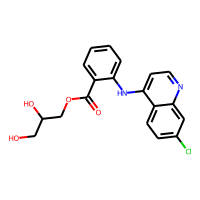
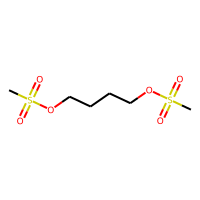
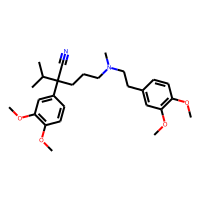
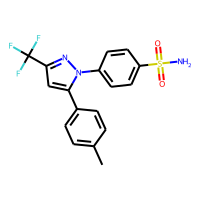
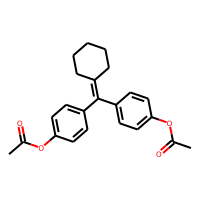
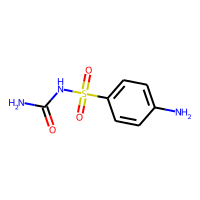
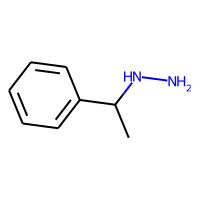
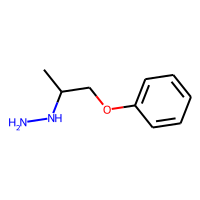
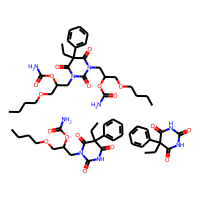
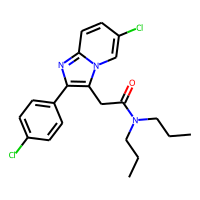

In [55]:
df

In [40]:
df.isna().sum()

PubChem                          0
CompoundName                     0
Drug label-based annotation      0
QSAR Prediction                193
PubChem_name                     0
cmpdsynonym                      2
mw                               0
mf                               0
polararea                        0
complexity                       0
xlogp                           23
heavycnt                         0
hbonddonor                       0
hbondacc                         0
rotbonds                         0
inchi                            0
Smiles                           0
inchikey                         0
iupacname                        0
meshheadings                   116
annothits                        0
annothitcnt                      0
aids                            23
cidcdate                         0
sidsrcname                       0
depcatg                          0
annotation                     327
DILI_label                       0
ROMol               

In [41]:
df.DILI_label.value_counts()

0.0    209
1.0    168
Name: DILI_label, dtype: int64

In [42]:
df[['Smiles', 'DILI_label']].to_csv('Output/DILI_labeled.smi', sep='\t', header=None, index=None)

### Features preparation and selection

In [53]:
def fp_bit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return np.array(morgan_fp, dtype=np.int32)

In [54]:
df['Fingerprint'] = df.Smiles.map(fp_bit)

,PubChem,CompoundName,Drug label-based annotation,QSAR Prediction,PubChem_name,cmpdsynonym,mw,mf,polararea,complexity,...,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,DILI_label,ROMol,Fingerprint
0,3474,glafenine,Most DILI-concern,NaN,Glafenine,glafenine|3820-67-5|Glaphenine|Glafenin|Glycer...,372.8,C19H17ClN2O4,91.7,467.0,...,Biological Test Results|Biomolecular Interacti...,9,700|875|880|881|884|885|887|889|892|893|894|90...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2478,busulfan,Most DILI-concern,NaN,Busulfan,busulfan|55-98-1|Myleran|Busulphan|Sulphabutin...,246.3,C6H14O6S2,104.0,294.0,...,Biological Test Results|Biomolecular Interacti...,13,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,2520,verapamil,Most DILI-concern,NaN,Verapamil,VERAPAMIL|52-53-9|Iproveratril|Vasolan|Dilacor...,454.6,C27H38N2O4,64.0,606.0,...,Biological Test Results|Biomolecular Interacti...,13,880|894|1030|1332|1379|1454|1457|1458|1460|146...,20050325,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2662,celecoxib,Most DILI-concern,NaN,Celecoxib,celecoxib|169590-42-5|Celebrex|Celebra|Onsenal...,381.4,C17H14F3N3O2S,86.4,577.0,...,Biological Test Results|Biomolecular Interacti...,13,1|5|7|9|19|21|23|25|29|31|33|35|37|39|41|43|45...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",1.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2898,cyclofenil,Most DILI-concern,NaN,Cyclofenil,cyclofenil|2624-43-3|Ondogyne|Cyclofenyl|Cyclo...,364.4,C23H24O4,52.6,503.0,...,Biological Test Results|Biomolecular Interacti...,11,1195|1469|1471|1477|1479|1490|1688|1766|1768|2...,20050325,001Chemical|3WAY PHARM INC|4C Pharma Scientifi...,Chemical Vendors|Curation Efforts|Governmental...,NaN,1.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

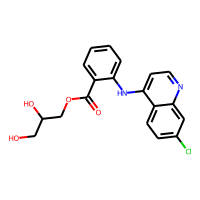
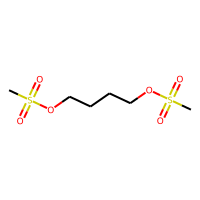
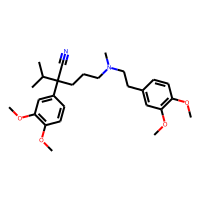
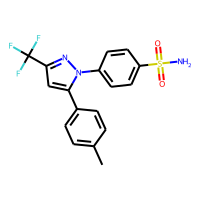
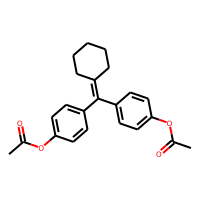

In [55]:
df.head()

In [77]:
fingerprints = pd.DataFrame(df.Fingerprint.to_list())

In [76]:
df.columns

Index(['PubChem', 'CompoundName', 'Drug label-based annotation',
       'QSAR Prediction', 'PubChem_name', 'cmpdsynonym', 'mw', 'mf',
       'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor',
       'hbondacc', 'rotbonds', 'inchi', 'Smiles', 'inchikey', 'iupacname',
       'meshheadings', 'annothits', 'annothitcnt', 'aids', 'cidcdate',
       'sidsrcname', 'depcatg', 'annotation', 'DILI_label', 'ROMol',
       'Fingerprint'],
      dtype='object')

In [127]:
mol_properties = df[['mw', 'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds']]

In [132]:
features = fingerprints
#features = mol_properties
#features = pd.concat([fingerprints, mol_properties, axis=1)

In [131]:
features.columns

Index(['mw', 'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor',
       'hbondacc', 'rotbonds'],
      dtype='object')

In [133]:
features.isna().sum()

0       0
1       0
2       0
3       0
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Length: 2048, dtype: int64

In [134]:
features.fillna(features.median(), inplace=True)

In [135]:
features.isna().any().value_counts()

False    2048
dtype: int64

In [136]:
X_train, X_test, y_train, y_test = train_test_split(features, df.DILI_label, random_state=10, test_size=0.2, shuffle=True)

In [137]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (301, 2048) (301,)
Testing set shape:  (76, 2048) (76,)


### Random Forest Classifier

In [138]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [139]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [140]:
predicted_rf = rf.predict(X_test)

In [141]:
print(ConfusionMatrix(y_test.ravel(), predicted_rf))

Predict   0.0       1.0       
Actual
0.0       30        12        

1.0       9         25        





Overall Statistics : 

95% CI                                                            (0.62315,0.82422)
ACC Macro                                                         0.72368
ARI                                                               0.18945
AUNP                                                              0.72479
AUNU                                                              0.72479
Bangdiwala B                                                      0.52659
Bennett S                                                         0.44737
CBA                                                               0.69498
CSI                                                               0.44724
Chi-Squared                                                       15.20159
Chi-Squared DF                                                    1
Conditional Entropy                                 

In [146]:
pd.DataFrame(rf.feature_importances_, index=features.columns).sort_values(0, ascending=False).head(10)

,0
981,0.011467
1380,0.010855
4,0.008148
1385,0.008049
1357,0.007290
1647,0.006705
650,0.006512
1928,0.006273
1457,0.005984
1160,0.005958


### SVM classifier

In [147]:
svm = SVC()

In [148]:
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [149]:
predicted_svm = svm.predict(X_test)

In [150]:
print(ConfusionMatrix(y_test.ravel(), predicted_svm))

Predict   0.0       1.0       
Actual
0.0       25        17        

1.0       12        22        





Overall Statistics : 

95% CI                                                            (0.50921,0.72764)
ACC Macro                                                         0.61842
ARI                                                               0.04348
AUNP                                                              0.62115
AUNU                                                              0.62115
Bangdiwala B                                                      0.38507
Bennett S                                                         0.23684
CBA                                                               0.57967
CSI                                                               0.24104
Chi-Squared                                                       4.41541
Chi-Squared DF                                                    1
Conditional Entropy                                  


# 0:50:00